In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({"font.size": 16})


import numpy as np
import tensorflow as tf
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# helpers

In [2]:
def scale_x_y(x, y):
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_x.fit(x)
    x = scaler_x.transform(x)
    scaler_y.fit(y)
    y = scaler_y.transform(y)

    return x, y

In [3]:
def sort_by_first(x, y):
    Xy = np.array(list(zip(x, y)))
    x_sorted, y_sorted = Xy[np.argsort(Xy[:, 0])].T
    return x_sorted, y_sorted

In [4]:
class PrintDot(tf.keras.callbacks.Callback):
    """
    Display training progress by printing a single dot for
    each completed epoch.
    """

    def on_epoch_end(self, epoch, logs) -> None:
        """
        `on_epoc_end` hook to take the epoch number and logs.
        This will run whenever the training loop finishes an epoch.
        """
        if epoch % 100 == 0:
            print("")
        print(".", end="")

In [190]:
def plot_prediction_comparison(X, y, models, labels, extrap=False):
    
    # data has been shuffled in train_test_split
    # so plotting a line plot is messy.
    # we fix this by sorting the data
    X, y = sort_by_first(X[:,0], y[:,0])
    
    
    yhats = []
    for model in models:
        yhats.append(model.predict(X)[:,0])
    
    if extrap:
        # extrapolate
        x_extrap = np.linspace(X.min(), X.max(), 1000)
        y_extrap = model.predict(x_extrap)[:,0]
    
    
    plt.figure(figsize=(14, 6))
    plt.plot(X, y, 'k-o', label='data')
    for i, yhat in enumerate(yhats):
        plt.plot(X, yhat, '-o', label=labels[i])
        
    if extrap:
        plt.plot(x_extrap, y_extrap, label='extrap', c='r', ls='--')
    plt.legend()
    plt.title("prediction")
    plt.show()
    plt.close()
    
    plt.figure(figsize=(14, 6))
    for i, yhat in enumerate(yhats):
        plt.plot(X, np.abs(y - yhat), label=labels[i])
    plt.yscale('log')
    plt.axhline(0.1, c='k', ls='-')
    plt.axhline(0.01, c='k', ls='--')
    plt.legend()
    plt.title("Absolute difference (log scale)")
    plt.show()
    plt.close()

# generate fake data

In [39]:
def gen_data(npts=1000):
    x = np.linspace(0, 1, npts)
    y = x + x ** 2 * np.sin(x * 2 * np.pi / 0.5)
    return x.reshape(-1, 1), y.reshape(-1, 1)

In [365]:
DATASET=2

if DATASET==1:
    # gen data
    X, y = gen_data(npts=100)

    # scale data
    X, y = scale_x_y(X, y)

elif DATASET==2:
    X, y = np.loadtxt("./scaled_data_to_fit.txt", unpack=True)
    X = X.reshape(-1,1)
    y = y.reshape(-1,1)



# split and shuffle data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# check shapes
for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)

(7500, 1)
(2500, 1)
(7500, 1)
(2500, 1)


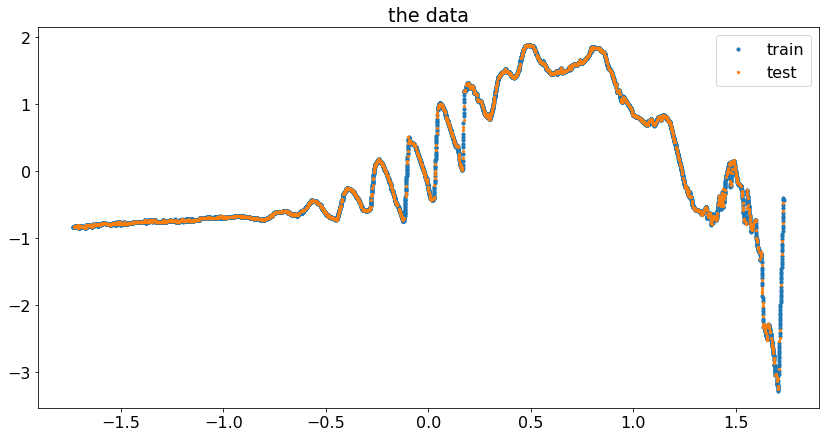

In [366]:
plt.figure(figsize=(14, 7))
plt.scatter(X_train, y_train, label='train', s=10)
plt.scatter(X_test, y_test, label='test', s=5)
plt.title('the data')
plt.legend()

# build models

In [367]:
def build_model(units=16, n_hidden_layers=2, activation='relu'):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units, input_dim=1, activation=activation))
    for i in range(n_hidden_layers):
        model.add(tf.keras.layers.Dense(units, activation=activation))
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.summary()
    return model

In [446]:
def compile_model(model, learning_rate=1e-3, optimizer=tf.keras.optimizers.Adam):
    opt = optimizer(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=opt, metrics=['mse'])
    
    return model

In [447]:
# model = build_model(units=32, n_hidden_layers=8, activation=tf.keras.layers.LeakyReLU(alpha=0.3))
model = build_model(units=256, n_hidden_layers=2, activation='relu')
# model = build_model(units=256, n_hidden_layers=2, activation=tf.keras.layers.LeakyReLU(alpha=0.3))

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_291 (Dense)            (None, 256)               512       
_________________________________________________________________
dense_292 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_293 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_294 (Dense)            (None, 1)                 257       
Total params: 132,353
Trainable params: 132,353
Non-trainable params: 0
_________________________________________________________________


In [448]:
model = compile_model(model, learning_rate=1e-3, optimizer=tf.keras.optimizers.Adam)
# model = compile_model(model, learning_rate=1e-3, optimizer=tf.keras.optimizers.Nadam)

In [449]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5, verbose=1, mode='min')
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,verbose=2, mode='auto')

In [450]:
# callbacks = [PrintDot()]
# callbacks = [PrintDot(), reduce_lr, es]
# callbacks = [PrintDot(), reduce_lr]
callbacks = [PrintDot()]

In [451]:
starttime = datetime.datetime.now()
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=1024,
    verbose=0,
    callbacks=callbacks,
    validation_data=(X_test, y_test)
)
endtime = datetime.datetime.now()

print('\nThe time cost: ')
print(endtime - starttime)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
The time cost: 
0:00:26.205442


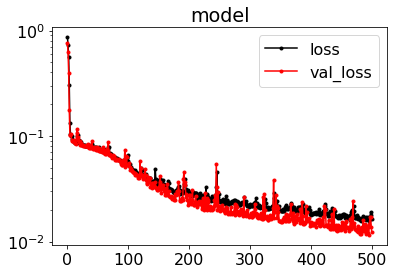

In [453]:
plt.figure()
plt.plot(history.history['loss'], 'k.-', label='loss')
plt.plot(history.history['val_loss'], 'r.-', label='val_loss')
plt.yscale('log')
plt.title('model')
plt.legend()

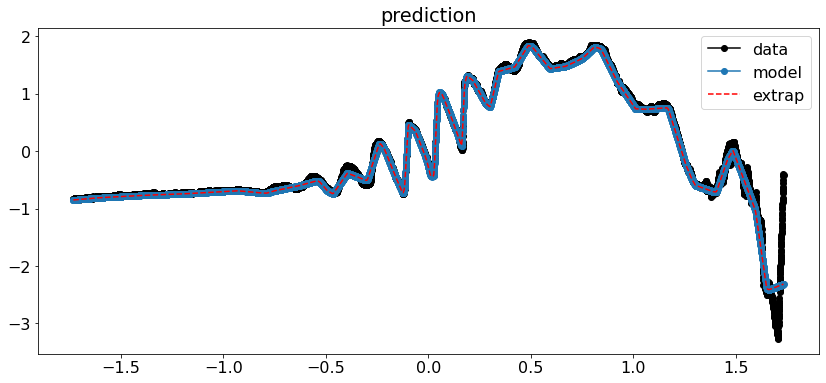

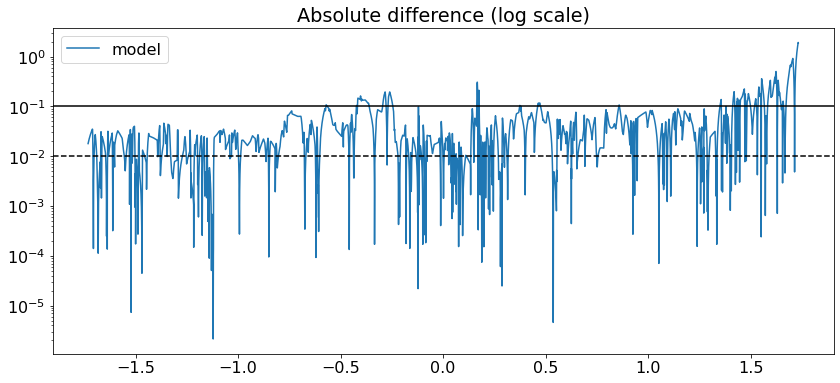

In [454]:
plot_prediction_comparison(X_train, y_train, [model], ['model'], extrap=True)